In [122]:
import pyreadr

import numpy as np
import pandas as pd

from sklearn import preprocessing
from scipy.special import comb, logsumexp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import random

In [123]:
PATH_BUILDING_ENERGY_LSTM_ZSCORE = "../data/building_energy_lstm_zscore.csv"
PATH_BUILDING_ENERGY_LSTM_UNDO_ZSCORE = "../data/building_energy_lstm_undo_zscore.csv"

random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

In [77]:
building_energy_lstm_zscore = pd.read_csv(PATH_BUILDING_ENERGY_LSTM_ZSCORE)
building_energy_lstm_undo_zscore = pd.read_csv(PATH_BUILDING_ENERGY_LSTM_UNDO_ZSCORE)

In [78]:
def stateful_cut(arr, batch_size, T_after_cut):
    if len(arr.shape) != 3:
        # N: Independent sample size,
        # T: Time length,
        # m: Dimension
        print("ERROR: please format arr as a (N, T, m) array.")

    N = arr.shape[0]
    T = arr.shape[1]

    # We need T_after_cut * nb_cuts = T
    nb_cuts = int(T / T_after_cut)
    if nb_cuts * T_after_cut != T:
        print("ERROR: T_after_cut must divide T")

    # We need batch_size * nb_reset = N
    # If nb_reset = 1, we only reset after the whole epoch, so no need to reset
    nb_reset = int(N / batch_size)
    if nb_reset * batch_size != N:
        print("ERROR: batch_size must divide N")

    # Cutting (technical)
    cut1 = np.split(arr, nb_reset, axis=0)
    cut2 = [np.split(x, nb_cuts, axis=1) for x in cut1]
    cut3 = [np.concatenate(x) for x in cut2]
    cut4 = np.concatenate(cut3)
    return(cut4)

In [79]:
NUM_BUILDINGS = len(building_energy_lstm_undo_zscore) # 29
NUM_TIME_VARIABLES = 3

# Groups by year and then removes year column
data_raw = np.array(list(building_energy_lstm_zscore.groupby('year').apply(pd.DataFrame.to_numpy)))[:, :, 1:]
X_raw = data_raw[:, :, :(NUM_BUILDINGS + NUM_TIME_VARIABLES)]
y_raw = data_raw[:, :, (NUM_BUILDINGS + NUM_TIME_VARIABLES):]

X_train = X_raw[:2]
X_val = X_raw[2:]
y_train = y_raw[:2]
y_val = y_raw[2:]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2, 8760, 32) (1, 8760, 32) (2, 8760, 29) (1, 8760, 29)


In [80]:
N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
batch_size = 1 # number of time series considered together: batch_size | N
T_after_cut = 73 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series

inputs, outputs, inputs_test, outputs_test = \
  [stateful_cut(arr, batch_size, T_after_cut) for arr in \
  [X_train, y_train, X_val, y_val]]

In [16]:
inputs.shape
outputs.shape

(240, 73, 29)

In [41]:
nb_units = 32
epochs = 100

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.2)
    
learningRateCallback = tf.keras.callbacks.LearningRateScheduler(scheduler)
earlyStoppingCallback = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=8, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(batch_input_shape=(batch_size, None, dim_in),
               return_sequences=True, units=nb_units, stateful=False))
model.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model.compile(loss = 'mae', optimizer = 'rmsprop')

history = model.fit(
    inputs, 
    outputs, 
    epochs = epochs,      
    batch_size = batch_size, 
    shuffle = True,
    validation_data = (inputs_test, outputs_test), 
    callbacks = [learningRateCallback, earlyStoppingCallback]
)

Train on 240 samples, validate on 120 samples
Epoch 1/100
240/240 [==============================] - 5s 22ms/step - loss: 0.6461 - val_loss: 0.6179
Epoch 2/100
240/240 [==============================] - 5s 20ms/step - loss: 0.5663 - val_loss: 0.5826
Epoch 3/100
240/240 [==============================] - 5s 20ms/step - loss: 0.5455 - val_loss: 0.5675
Epoch 4/100
240/240 [==============================] - 5s 20ms/step - loss: 0.5191 - val_loss: 0.5562
Epoch 5/100
240/240 [==============================] - 5s 21ms/step - loss: 0.5010 - val_loss: 0.5466
Epoch 6/100
240/240 [==============================] - 5s 21ms/step - loss: 0.4856 - val_loss: 0.5428
Epoch 7/100
240/240 [==============================] - 5s 21ms/step - loss: 0.4786 - val_loss: 0.5453
Epoch 8/100
240/240 [==============================] - 5s 21ms/step - loss: 0.4708 - val_loss: 0.5442
Epoch 9/100
240/240 [==============================] - 5s 21ms/step - loss: 0.4681 - val_loss: 0.5395
Epoch 10/100
240/240 [==============

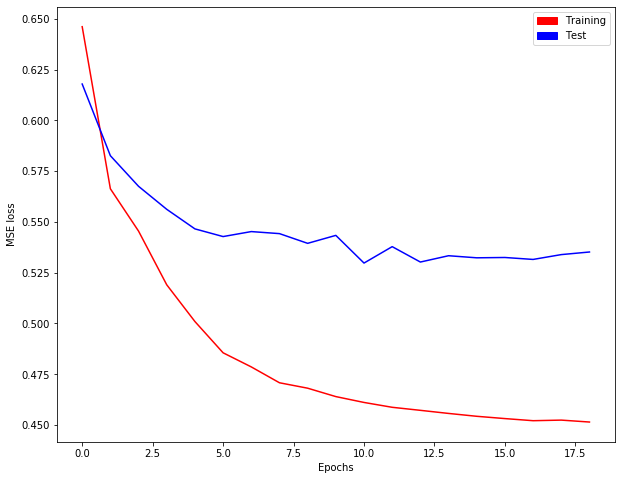

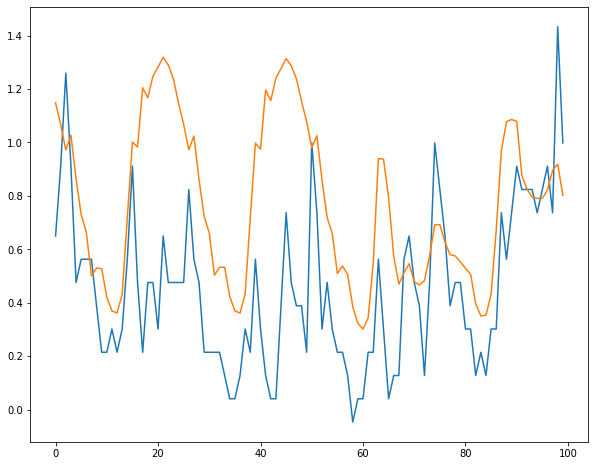

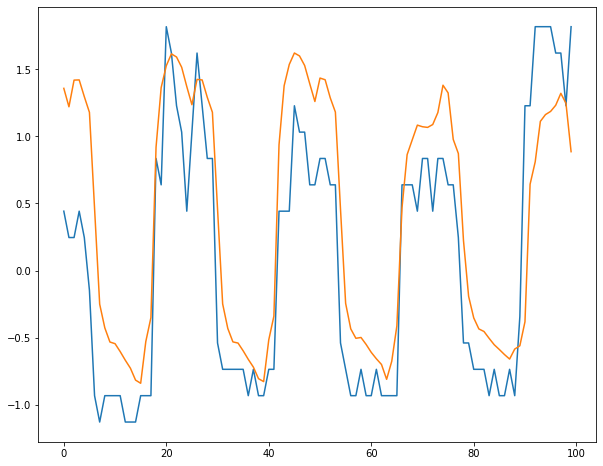

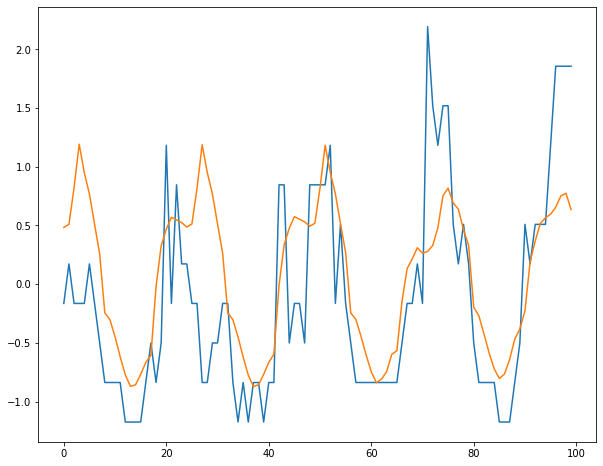

In [42]:
def plotting(history):
    plt.plot(history.history['loss'], color = "red")
    plt.plot(history.history['val_loss'], color = "blue")
    red_patch = mpatches.Patch(color='red', label='Training')
    blue_patch = mpatches.Patch(color='blue', label='Test')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.show()

plt.figure(figsize=(10,8))
plotting(history) # Evolution of training/test loss

## Prediction of a new set
i = 0 # time series selected (between 0 and N-1)
x = X_train[i]
y = y_train[i]
y_hat = model.predict(np.array([x]))[0]

plot_steps = 100 # T

for dim in range(3): # dim = 0 for y1 ; dim = 1 for y2 ; dim = 2 for y3.
    plt.figure(figsize=(10,8))
    plt.plot(range(100), y[4000:4100,dim])
    plt.plot(range(100), y_hat[4000:4100,dim])
    plt.show()

In [57]:
true_y_val = (y_val * np.array([building_energy_lstm_undo_zscore['sd_kwh']]) + np.array([building_energy_lstm_undo_zscore['mean_kwh']])).flatten()
true_y_predictions = (model.predict(X_val) * np.array([building_energy_lstm_undo_zscore['sd_kwh']]) + np.array([building_energy_lstm_undo_zscore['mean_kwh']])).flatten()
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 42.477939744423296
CV(RMSE): 28.966482521012313
MBE: 5.04348632674192


In [ ]:
X = np.array(building_energy_scaled.drop(columns=['kwh_actual']))
y = np.array(building_energy_scaled.filter(items=['kwh_actual']))

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

train_undo_zscore = X_train[:, 4:6]
val_undo_zscore = X_val[:, 4:6]
test_undo_zscore = X_test[:, 4:6]

X_train = np.delete(X_train, [4, 5], 1)
X_val = np.delete(X_val, [4, 5], 1)
X_test = np.delete(X_test, [4, 5], 1)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

In [124]:
PATH_BUILDING_ENERGY_FEATURIZED_ZSCORE = "../data/building_energy_featurized_zscore.csv"
PATH_BUILDING_ENERGY_FEATURIZED_UNDO_ZSCORE = "../data/building_energy_featurized_undo_zscore.csv"

# building_energy_featurized_zscore = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED_ZSCORE)
# building_energy_featurized_undo_zscore = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED_UNDO_ZSCORE)
x_temporary = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED_ZSCORE)
#building_energy_featurized_undo_zscore = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED_UNDO_ZSCORE)
#BUILDING_ENERGY_DATASET = building_energy_featurized_zscore

In [125]:
#building_energy_scaled = BUILDING_ENERGY_DATASET

# Scale temporal variables via simple minmax (because they are roughly uniformly distributed)
min_max_scaler = preprocessing.MinMaxScaler()
x_temporary[['year', 'month', 'day', 'hour']] = min_max_scaler.fit_transform(x_temporary[['year', 'month', 'day', 'hour']])

In [126]:
x_temporary = np.array(x_temporary)
undo_zscore = x_temporary[:, 5:7]
x_temporary = np.delete(x_temporary, [5, 6], 1)

In [127]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [128]:
future_target = 1 # predict 12 hours into the future, changed to 1
TRAIN_SPLIT = 762793 - future_target
BATCH_SIZE = 128
BUFFER_SIZE = 1000
past_history = 24 # previously 120 ran out of memory # use 5 days of past data to predict
STEP = 1 # sampling frequency is one hour

x_train_single, y_train_single = multivariate_data(np.delete(x_temporary, 4, 1), x_temporary[:, 4], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)
#x_val_single, y_val_single = multivariate_data(np.delete(x_temporary, 4, 1), x_temporary[:, 4], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [22]:
#x_train_single, x_val_single, y_train_single, y_val_single = train_test_split(x_train_single, y_train_single, test_size=0.3, shuffle = True)

In [129]:
random_indices = np.arange(x_train_single.shape[0])

In [130]:
x_train_single = x_train_single[random_indices]
y_train_single = y_train_single[random_indices]
undo_zscore = undo_zscore[past_history + future_target:]
undo_zscore = undo_zscore[random_indices]

In [131]:
VAL_FRACTION = 0.3
split_point = y_train_single.shape[0] - int(y_train_single.shape[0] * VAL_FRACTION)

In [132]:
x_val_single = x_train_single[split_point:]
y_val_single = y_train_single[split_point:]
undo_zscore = undo_zscore[split_point:]

x_train_single = x_train_single[:split_point]
y_train_single = y_train_single[:split_point]

In [133]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (24, 74)


In [134]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

train_val_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
train_val_single = train_val_single.batch(BATCH_SIZE).repeat()

In [142]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(512, input_shape=np.array([24, 74])))
#single_step_model.add(tf.keras.layers.LSTM(128))
single_step_model.add(tf.keras.layers.Dense(1))

# Todo: Play around with optimizer???
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [135]:
79880 / 32

2496.25

In [143]:
single_step_history = single_step_model.fit(train_data_single, epochs=10,
                                            steps_per_epoch=int(np.ceil(x_train_single.shape[0] / BATCH_SIZE)),
                                            shuffle = True,
                                            validation_data=train_val_single,
                                            validation_steps=int(np.ceil(x_val_single.shape[0] / BATCH_SIZE))) # change steps per epoch to all later

## MAYBE MODIFY LSTM COMPLEXITY???? also compare with shuffled training/validation sets for original basic NN model cuz it's obviously hard to predict on a building you haven't seen dumbass

Epoch 1/10
4172/4172 [==============================] - 3554s 852ms/step - loss: 0.3892 - val_loss: 0.5953
Epoch 2/10
4172/4172 [==============================] - 3619s 867ms/step - loss: 0.3748 - val_loss: 0.6086
Epoch 3/10
4172/4172 [==============================] - 3623s 868ms/step - loss: 0.3728 - val_loss: 0.5882
Epoch 4/10
4172/4172 [==============================] - 3624s 869ms/step - loss: 0.3664 - val_loss: 0.5479
Epoch 5/10
4172/4172 [==============================] - 3629s 870ms/step - loss: 0.3624 - val_loss: 0.5441
Epoch 6/10
4172/4172 [==============================] - 3626s 869ms/step - loss: 0.3668 - val_loss: 0.5725
Epoch 7/10
4172/4172 [==============================] - 3627s 869ms/step - loss: 0.3651 - val_loss: 0.5467
Epoch 8/10
4172/4172 [==============================] - 3629s 870ms/step - loss: 0.3646 - val_loss: 0.5743
Epoch 9/10
4172/4172 [==============================] - 3691s 885ms/step - loss: 0.3601 - val_loss: 0.5570
Epoch 10/10
4172/4172 [==============

In [144]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

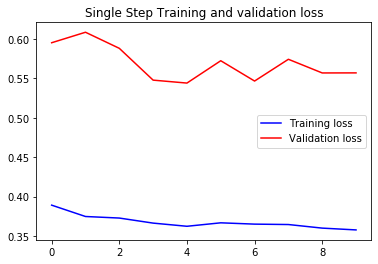

In [145]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [79]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [80]:
for x, y in val_data_single.take(10):
    plot = show_plot([x[0][:, 4].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

NameError: name 'val_data_single' is not defined

In [146]:
temp_undo_zscore = undo_zscore

In [147]:
true_y_predictions = single_step_model.predict(x_val_single).flatten() * temp_undo_zscore[:, 1] + temp_undo_zscore[:, 0]
true_y_val = y_val_single * temp_undo_zscore[:, 1] + temp_undo_zscore[:, 0]

y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 26.279737368878912
CV(RMSE): 32.95004107066594
MBE: -4.699632431634537
